# Convex approximate dynamic programming

We consider a stochastic control problem of the form
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & \underset{T \to \infty}\lim {\mathbb E} \left[\frac{1}{T} \sum_{t=0}^{T-1} \|{x_t}\|_2^2 + \|{\phi(x_t)}\|_2^2\right]\\[.2cm]
\mbox{subject to} & x_{t+1} = Ax_t + B\phi(x_t) + \omega_t,
\end{array}
\label{eq:adp}
\end{equation}
where $x_t\in\mathbf{R}^n$ is the state, $\phi:\mathbf{R}^n \to \mathcal U \subseteq \mathbf{R}^m$ is
the policy, $\mathcal U$ is a convex set representing the allowed set of controls,
and $\omega_t\in\Omega$ is a (random, i.i.d.) disturbance.
Here the variable is the policy $\phi$, and the expectation is taken over
disturbances and the initial state $x_0$. If $\mathcal U$ is not an affine
set, then this problem is in general very difficult to solve.

A common heuristic for solving stochastic control problems is
approximate dynamic programming (ADP), which parametrizes $\phi$
and replaces the minimization over functions $\phi$ with a minimization over parameters.
In this example, we take $\mathcal U$ to be the unit ball and we represent $\phi$
as a particular quadratic *control-Lyapunov* policy.
Evaluating $\phi$ corresponds to solving the SOCP
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & u^T P u + x_t^T Q u + q^T u \\
\mbox{subject to} & \|{u}\|_2 \leq 1,
\end{array}
\label{eq:policy}
\end{equation}
with variable $u$ and parameters $P$, $Q$, $q$, and $x_t$. We can run
stochastic gradient descent (SGD) on $P$, $Q$, and $q$ to
approximately solve the original problem, which requires requires differentiating
through the quadratic policy. Note that if $u$ were unconstrained, the original problem
could be solved exactly, via linear quadratic regulator (LQR) theory.

In [1]:
import cvxpy as cp
import numpy as np
import tensorflow as tf
from scipy.linalg import solve_discrete_are
from scipy.linalg import sqrtm


from cvxpylayers.tensorflow.cvxpylayer import CvxpyLayer


# Generate data
tf.random.set_seed(1)
np.random.seed(1)

n = 2
m = 3

A = np.eye(n) + 1e-2 * np.random.randn(n, n)
B = 1e-2 / 3 * np.random.randn(n, m)
Q = np.eye(n)
R = np.eye(m)

# Compute LQR control policy
P_lqr = solve_discrete_are(A, B, Q, R)
P = R + B.T@P_lqr@B
P_sqrt_lqr = sqrtm(P)

# Construct CVXPY problem and layer
x_cvxpy = cp.Parameter((n, 1))
P_sqrt_cvxpy = cp.Parameter((m, m))
P_21_cvxpy = cp.Parameter((n, m))
q_cvxpy = cp.Parameter((m, 1))

u_cvxpy = cp.Variable((m, 1))
y_cvxpy = cp.Variable((n, 1))

objective = .5 * cp.sum_squares(P_sqrt_cvxpy @ u_cvxpy) + x_cvxpy.T @ y_cvxpy + q_cvxpy.T @ u_cvxpy
problem = cp.Problem(cp.Minimize(objective), [cp.norm(u_cvxpy) <= 1, y_cvxpy == P_21_cvxpy @ u_cvxpy])
assert problem.is_dpp()
policy = CvxpyLayer(
    problem, [x_cvxpy, P_sqrt_cvxpy, P_21_cvxpy, q_cvxpy], [u_cvxpy])

Below, we train the policy and plot the estimated average cost for each iteration of
SGD for a numerical example, with $x \in
\mathbf{R}^2$ and $u \in \mathbf{R}^3$, a time horizon of $T=25$, and a batch
size of $8$. We initialize our policy's parameters with the LQR solution,
ignoring the constraint on $u$.

In [2]:
import matplotlib.pyplot as plt


def train(iters):
    # Initialize with LQR control lyapunov function
    P_sqrt = tf.Variable(P_sqrt_lqr)
    P_21 = tf.Variable(A.T @ P_lqr @ B)
    q = tf.Variable(tf.zeros((m, 1), dtype=tf.float64))
    variables = [P_sqrt, P_21, q]
    A_tf, B_tf, Q_tf, R_tf = map(tf.constant, [A, B, Q, R])

    def g(x, u):
        return tf.squeeze(tf.transpose(x) @ Q_tf @ x + tf.transpose(u) @ R_tf @ u)

    def evaluate(x0, P_sqrt, P_21, q, T):
        x = x0
        cost = 0.
        for _ in range(T):
            u, = policy(x, P_sqrt, P_21, q)
            cost += g(x, u) / T
            x = A_tf @ x + B_tf @ u + .2 * tf.random.normal((n, 1), dtype=tf.float64)
        return cost

    def eval_loss(N=8, T=25):
        return sum([evaluate(tf.zeros((n, 1), dtype=tf.float64), P_sqrt, P_21, q, T=T)
                    for _ in range(N)]) / N

    results = []
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
    for i in range(iters):
        tf.random.set_seed(1)
        np.random.seed(1)
        with tf.GradientTape() as tape:
            loss = eval_loss()
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        results.append(loss.numpy())
        print("(iter %d) loss: %g " % (i, results[-1]))
    return results


results = train(iters=100)

(iter 0) loss: 1.18634 
(iter 1) loss: 1.17733 
(iter 2) loss: 1.16115 
(iter 3) loss: 1.13998 
(iter 4) loss: 1.11706 
(iter 5) loss: 1.09234 
(iter 6) loss: 1.06502 
(iter 7) loss: 1.03633 
(iter 8) loss: 1.00895 
(iter 9) loss: 0.982198 
(iter 10) loss: 0.954998 
(iter 11) loss: 0.926645 
(iter 12) loss: 0.900704 
(iter 13) loss: 0.874988 
(iter 14) loss: 0.851813 
(iter 15) loss: 0.829279 
(iter 16) loss: 0.809518 
(iter 17) loss: 0.79314 
(iter 18) loss: 0.77915 
(iter 19) loss: 0.767274 
(iter 20) loss: 0.756987 
(iter 21) loss: 0.74633 
(iter 22) loss: 0.735943 
(iter 23) loss: 0.725892 
(iter 24) loss: 0.716452 
(iter 25) loss: 0.70797 
(iter 26) loss: 0.700616 
(iter 27) loss: 0.694235 
(iter 28) loss: 0.688617 
(iter 29) loss: 0.683476 
(iter 30) loss: 0.678953 
(iter 31) loss: 0.67472 
(iter 32) loss: 0.670976 
(iter 33) loss: 0.667654 
(iter 34) loss: 0.664699 
(iter 35) loss: 0.662062 
(iter 36) loss: 0.659702 
(iter 37) loss: 0.657582 
(iter 38) loss: 0.655674 
(iter 39) 

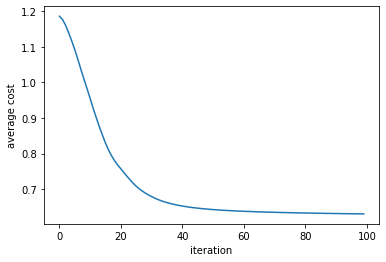

In [3]:
plt.figure()
plt.plot(results)
plt.xlabel('iteration')
plt.ylabel('average cost')
plt.show()